In [1]:
varsels = ['input_order', 'first_fail', 'smallest', 'largest']
valsels = ['indomain_min', 'indomain_max', 'indomain_median', 'indomain_random']
datasets = [f'prepare{n}.dzn' for n in range(1,15)]
small_datasets = datasets[:6]
large_datasets = datasets[6:]

results = {}

from tqdm import tqdm
import re
import matplotlib.pyplot as plt

class SearchStrategy :
    def __init__(self, varsel, valsel) -> None:
        self.varsel = varsel
        self.valsel = valsel

        self.outputs_sat = []
        self.failed = []
        
        self.outputs_min = []
        self.optimum_proved = []
        self.first_sols = []
        self.final_sols = []

search_strategies = {}

### Solving :
How many failures to find a first solution ?
Let's run the sat version with every config

In [2]:
model = "prepare_sat.mzn"
time_limit_ms = 60_000
with tqdm(total=4*4*14) as pbar :
    for varsel in varsels :
        for valsel in valsels :
            search_strategies[(varsel,valsel)] = SearchStrategy(varsel, valsel)
            for dataset in datasets :
                pbar.set_postfix_str(varsel + valsel + dataset)
                output = !minizinc -s {model} data/{dataset} \
                                        -D"varsel={varsel};valsel={valsel}" --fzn-flags '--time {time_limit_ms}'
                
                failed = re.search(r".*----------.*","".join(output)) is None

                search_strategies[(varsel,valsel)].outputs_sat.append(output)
                search_strategies[(varsel,valsel)].failed.append(failed)
                pbar.update()

 43%|████▎     | 96/224 [00:08<00:11, 11.52it/s, largestindomain_randomprepare6.dzn]    


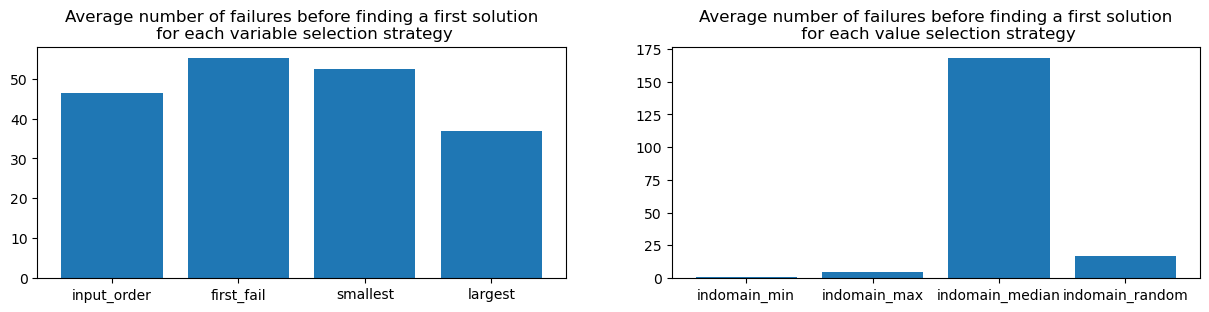

In [3]:
def get_mean_failures(search_strategies, varsel, valsel) :
    failures = 0
    n_values = 0
    for i in search_strategies[varsel,valsel].outputs_sat :
        f = re.search(".*failures=(?P<f>\d+).*","".join(i))
        if f is not None : 
            failures += int(f.group('f'))
            n_values += 1
        else :
            print(f'{varsel} {valsel} Failed to find any solution with dataset {i}')
    return failures/n_values

varsels_failures = {vr : 0 for vr in varsels}
valsels_failures = {vl : 0 for vl in valsels}
for strat in search_strategies.values() :
    failures = get_mean_failures(search_strategies, strat.varsel, strat.valsel)
    varsels_failures[strat.varsel] += failures
    valsels_failures[strat.valsel] += failures

plt.figure(figsize=(15,3))

plt.subplot(1,2,1)
plt.bar(varsels, varsels_failures.values())
plt.title('Average number of failures before finding a first solution\n for each variable selection strategy')

plt.subplot(1,2,2)
plt.bar(valsels, valsels_failures.values())
plt.title('Average number of failures before finding a first solution\n for each value selection strategy')   
plt.show()  

First_fail, Input_order and InDomain_Max stand out as more *clever* on this example (they fail less)

### Completeness
How often do the strategies prove the optimal solution ?
We run the minimization version here

In [4]:
model = "prepare.mzn"
time_limit_ms = 60_000

with tqdm(total=4*4*14) as pbar :
    for varsel in varsels :
        for valsel in valsels :
            search_strategies[(varsel,valsel)] = SearchStrategy(varsel, valsel)
            for dataset in datasets :
                pbar.set_postfix_str(varsel + valsel + dataset)
                output = !minizinc -s -a {model} data/{dataset} \
                                        -D"varsel={varsel};valsel={valsel}" --fzn-flags '--time {time_limit_ms}'

                first_sol = re.search(r".*makespan = (?P<f>\d+).*","".join(output))
                if first_sol is not None :
                    search_strategies[(varsel,valsel)].first_sols.append(first_sol.group('f'))

                final_sol = re.search(r".*makespan = (?P<f>\d+).*","".join(output))
                if final_sol is not None :
                    search_strategies[(varsel,valsel)].final_sols.append(first_sol.group('f'))
                
                optimum = re.search(r".*==========.*","".join(output)) is not None
                search_strategies[(varsel,valsel)].outputs_min.append(output)
                search_strategies[(varsel,valsel)].optimum_proved.append(optimum)
                pbar.update()

 43%|████▎     | 96/224 [00:46<01:01,  2.08it/s, largestindomain_randomprepare6.dzn]    


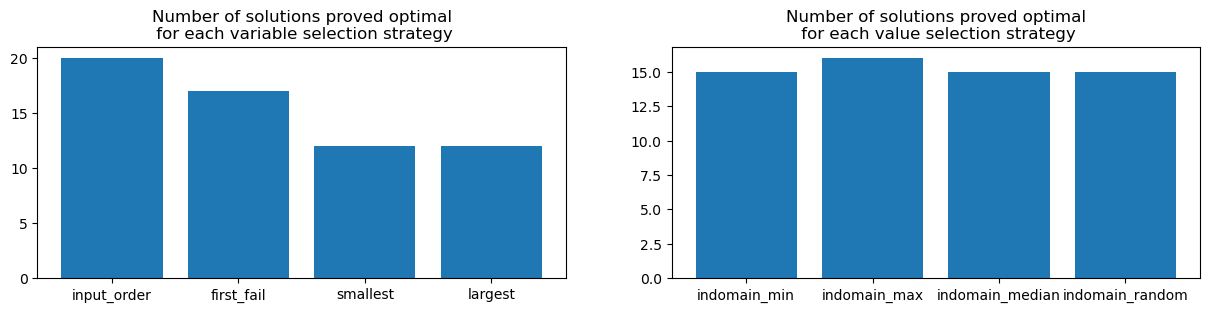

In [5]:
varsels_n_proved = {vr : 0 for vr in varsels}
valsels_n_proved = {vl : 0 for vl in valsels}
for strat in search_strategies.values() :
    n_proved = sum(strat.optimum_proved)
    varsels_n_proved[strat.varsel] += n_proved
    valsels_n_proved[strat.valsel] += n_proved

plt.figure(figsize=(15,3))

plt.subplot(1,2,1)
plt.bar(varsels, varsels_n_proved.values())
plt.title('Number of solutions proved optimal\n for each variable selection strategy')

plt.subplot(1,2,2)
plt.bar(valsels, valsels_n_proved.values())
plt.title('Number of solutions proved optimal\n for each value selection strategy')   
plt.show()  

Again, Input_order, first_fail, and InDomain_min seem to perform better

### Search Space
How many failures to prove the optimum ?

In [6]:
# For a fair comparison, we only use datasets which were proven by every strategy
for strat in search_strategies.values() :
    print(f"{strat.varsel} {strat.valsel} failed to prove optimum on \
        {[None if strat.optimum_proved[i] else i for i in range(len(strat.optimum_proved))]}")

input_order indomain_min failed to prove optimum on         [None, None, None, None, None, 5]
input_order indomain_max failed to prove optimum on         [None, None, None, None, None, 5]
input_order indomain_median failed to prove optimum on         [None, None, None, None, None, 5]
input_order indomain_random failed to prove optimum on         [None, None, None, None, None, 5]
first_fail indomain_min failed to prove optimum on         [None, None, None, None, 4, 5]
first_fail indomain_max failed to prove optimum on         [None, None, None, None, None, 5]
first_fail indomain_median failed to prove optimum on         [None, None, None, None, 4, 5]
first_fail indomain_random failed to prove optimum on         [None, None, None, None, 4, 5]
smallest indomain_min failed to prove optimum on         [None, None, None, 3, 4, 5]
smallest indomain_max failed to prove optimum on         [None, None, None, 3, 4, 5]
smallest indomain_median failed to prove optimum on         [None, None, None, 

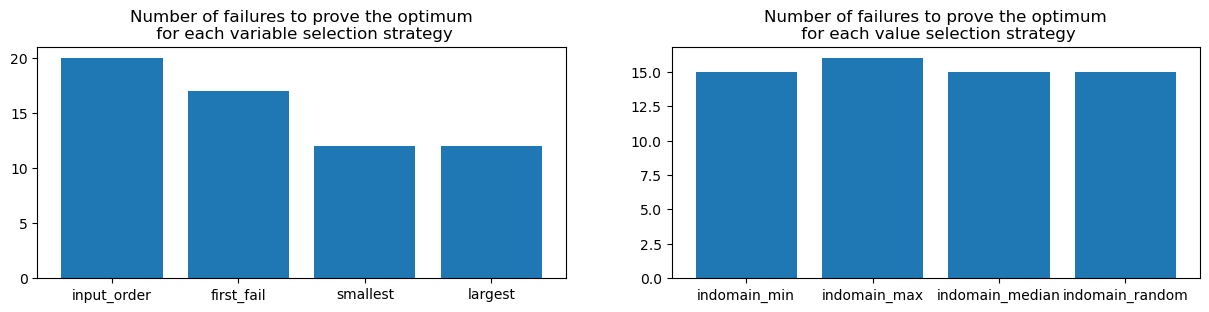

In [7]:
varsels_n_failures_for_optimum = {vr : 0 for vr in varsels}
valsels_n_failures_for_optimum = {vl : 0 for vl in valsels}
for strat in search_strategies.values() :
    failures = 0
    for i in search_strategies[varsel,valsel].outputs_min[:4] :
        f = re.search(".*failures=(?P<f>\d+).*","".join(i))
        if f is not None : 
            failures += int(f.group('f'))
    varsels_n_failures_for_optimum[strat.varsel] += failures
    valsels_n_failures_for_optimum[strat.valsel] += failures

plt.figure(figsize=(15,3))

plt.subplot(1,2,1)
plt.bar(varsels, varsels_n_proved.values())
plt.title('Number of failures to prove the optimum\n for each variable selection strategy')

plt.subplot(1,2,2)
plt.bar(valsels, valsels_n_proved.values())
plt.title('Number of failures to prove the optimum\n for each value selection strategy')   
plt.show()  

### First Solution
How good is the first solution ?

In [9]:
varsels_mean_first_sol = {vr : 0 for vr in varsels}
valsels_mean_first_sol = {vl : 0 for vl in valsels}
for strat in search_strategies.values() :
    failures = 0
    for i in search_strategies[varsel,valsel].outputs_min[:4] :
        f = re.search(".*failures=(?P<f>\d+).*","".join(i))
        if f is not None : 
            failures += int(f.group('f'))
    varsels_n_failures_for_optimum[strat.varsel] += failures
    valsels_n_failures_for_optimum[strat.valsel] += failures

# plt.figure(figsize=(15,3))

# plt.subplot(1,2,1)
# plt.bar(varsels, varsels_n_proved.values())
# plt.title('Number of failures to prove the optimum\n for each variable selection strategy')

# plt.subplot(1,2,2)
# plt.bar(valsels, valsels_n_proved.values())
# plt.title('Number of failures to prove the optimum\n for each value selection strategy')   
# plt.show()  